# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [1]:
# all import statements needed for the project, for example:
import re
import bs4
import math
import warnings
import requests
import mapclassify
import numpy as np
import pandas as pd
import sqlalchemy as db
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import stats
from keplergl import KeplerGl
from math import sin, cos, asin, pi, sqrt

warnings.filterwarnings('ignore')

In [2]:
# constants we need for processing data:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "query-"

## Part 1: Data Preprocessing

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Define a function that calculates the distance between two coordinates in kilometers that **only uses the `math` module** from the standard library.
* [ ] Taxi data:
    * [ ] Use the `re` module, and the packages `requests`, BeautifulSoup (`bs4`), and (optionally) `pandas` to programmatically download the required CSV files & load into memory.
    * You may need to do this one file at a time - download, clean, sample. You can cache the sampling by saving it as a CSV file (and thereby freeing up memory on your computer) before moving onto the next file. 
* [ ] Weather & Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
* [ ] All data:
    * [ ] Load the data using `pandas`
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * (Taxi & Uber data) Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] (Taxi data) Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
* [ ] Weather data:
    * [ ] Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
    * [ ] You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 

### Calculating distance
_Using the latituede/longitude given in the Yellow Taxi Dataframe to calculate the route distance._

In [3]:
def calculate_distance(from_coord, to_coord):
    """
    Calculate the distance between two coordinates
    
    The function takes in 2 argumants: "from_coord" and "to_coord"
    "from_coord": columns 'pickup_latitude' and 'pickup_longitude' from datarame
    "to_coord":  columns 'dropoff_latitude' and 'dropoff_longitude' from datarame
    
    RETURN: an array of calculated distances (in km)
    """
    # first change the latitude and longitude into radians
    lat1 = from_coord['pickup_latitude'] *pi/180
    lon1 = from_coord['pickup_longitude'] *pi/180
    lat2 = to_coord['dropoff_latitude']*pi/180
    lon2 = to_coord['dropoff_longitude']*pi/180
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    
    # using Haversine formula to calculate distance
    a = ((dlat/2).map(sin))**2 + (lat1.map(cos)) * (lat2.map(cos)) * ((dlon/2).map(sin))**2
    
    # suppose the radius of earth is 6371 km
    distance = 6371*2 * (a.map(sqrt)).map(asin)
    
    # round the distance with 2 decimals
    return round(distance, 2)

In [4]:
def add_distance_column(dataframe):
    """
    Add one column 'distance' which calculates taxi route distance into 'dataframe'
    
    The function takes one argument: 'dataframe'
    Use columns "pickup_latitude" and "pickup_longitude" to create argument "from_coord"
    Use columns "dropoff_latitude" and "dropoff_longitude" to create argument to_coord"
    
    RETURN: dataframe with new column 'distance' 
    """
    # generate 'from_coord' & 'to_coord'
    from_coord = dataframe[['pickup_latitude', 'pickup_longitude']]
    to_coord = dataframe[['dropoff_latitude', 'dropoff_longitude']]
    
    # add 'distance' into dataframe
    dataframe['distance'] = calculate_distance(from_coord, to_coord)
    
    return dataframe

### Processing Taxi Data

_Obtain Yellow Taxi Data from 2009-01 to 2015-06, then clean and combine all dataframes._

_Firstly we utilize `re`, `requests` and `BeautifulSoup` module to find specific data._

_Then we use `pandas` to load and clean the monthly data according to our rules._

_Finally we combine each monthly data into a giant one._

In [5]:
def find_taxi_csv_urls():
    """
    Get all the URLs of Taxi Data
    RETURN: a lits of links that download parquet files of Taxi Data
    """
    y = []
    links = []
    # get response from HTML
    response = requests.get(TAXI_URL)
    html = response.content
    
    # use bs4 to parse html and find Yellow Taxi urls
    soup = bs4.BeautifulSoup(html, "html.parser")
    yellow = soup.find_all("a", attrs = {"title":"Yellow Taxi Trip Records"})
    y.append([a["href"] for a in yellow])
    
    # use regex pattern to find desired URLs from 'yellow taxi trip records'
    pattern = re.compile(".*(2009|201[0-4]|2015-0[1-6]).*")
    for i in y[0]:
        match = re.match(pattern, i)
        if match != None:
            links.append(i)
    return links

In [6]:
def get_and_clean_month_taxi_data(url):
    """
    The function takes in one url from Internet
    Obtain dataframe from url of every given month and clean the df
    
    RETURN: a cleaned dataframe
    """   
    # Load shp file of Taxi Zones
    g = gpd.read_file(filename='taxi_zones.zip', engine='fiona')
    g = g.to_crs(4326)

    # use the center of the zones as a point to look up the coordinates.
    g['longitude'] = g.centroid.x
    g['latitude'] = g.centroid.y

    # remove unnecessary columns 
    # create mapping methods for latitude & longitude
    # aim to create lat & longitude which do not exist in some taxi data
    g = g[['LocationID', 'longitude', 'latitude', 'zone', 'borough']]
    lat_map = dict(zip(g['LocationID'], g['latitude']))
    lon_map = dict(zip(g['LocationID'], g['longitude']))
    
    df = pd.read_parquet(url)
    
    # process dataframe which only has LocationIDs 
    # match the LocationID in 'df' with dataframe 'g'
    # add 4 new columns to 'df' after matching
    if 'DOLocationID' in df:
        df['pickup_latitude']  = df['PULocationID'].map(lat_map)
        df['pickup_longitude'] = df['PULocationID'].map(lon_map)
        df['dropoff_latitude'] = df['DOLocationID'].map(lat_map)
        df['dropoff_longitude']= df['DOLocationID'].map(lon_map)

    # normalizing column names, according to UBER_DATA column names
    df = df.rename(columns={'tpep_pickup_datetime':'pickup_datetime', 
                            'Trip_Pickup_DateTime':'pickup_datetime', 
                            'Tip_Amt':'tip_amount',
                            'Fare_Amt':'fare_amount', 'Passenger_Count':'passenger_count',
                            'Start_Lon':'pickup_longitude','Start_Lat':'pickup_latitude', 
                            'End_Lon':'dropoff_longitude', 'End_Lat':'dropoff_latitude',           
                            })
        
    # remove invalid ponits, fare, distance and passenger must be positive
    df = df[df['fare_amount'] > 0]
    df = df[(df['tip_amount'] >= 0)]
    df = df[df['passenger_count'] > 0]
    df = df[df['pickup_latitude']!=df['dropoff_latitude']]
    df = df[df['pickup_longitude']!=df['dropoff_longitude']]
    df = df[abs(df['pickup_longitude']-df['dropoff_longitude'])>0.001]
        
    # removing trips that start and/or end outside of the BOX
    df = df[df['pickup_latitude'] >= NEW_YORK_BOX_COORDS[0][0]]
    df = df[df['pickup_latitude'] <= NEW_YORK_BOX_COORDS[1][0]]
    df = df[df['pickup_longitude'] >= NEW_YORK_BOX_COORDS[0][1]]
    df = df[df['pickup_longitude'] <= NEW_YORK_BOX_COORDS[1][1]]
        
    df = df[df['dropoff_latitude'] >= NEW_YORK_BOX_COORDS[0][0]]
    df = df[df['dropoff_latitude'] <= NEW_YORK_BOX_COORDS[1][0]]
    df = df[df['dropoff_longitude'] >= NEW_YORK_BOX_COORDS[0][1]]
    df = df[df['dropoff_longitude'] <= NEW_YORK_BOX_COORDS[1][1]]
    
    # remove unnecessary columns, only keep 6 columns we need
    df = df[['pickup_datetime','tip_amount',
             'pickup_latitude','pickup_longitude',
             'dropoff_latitude','dropoff_longitude',
            ]]
    # sampling from data to match the amount of "taxi_data" with "uber_data" 
    df = df.sample(n=round(185444/78))
    
    # using appropriate column type
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df.iloc[:,1:6] = df.iloc[:,1:6].astype('float32')     
    
    return df

In [7]:
def get_and_clean_taxi_data():
    """
    The function generate a list of Yellow Taxi urls
    For each url, obtain the dataframe from url
    Then clean dataframe and add 'distance' column
    In the end we join each month's dataframe to a giant one
    
    RETURN: a huge dataframe contains cleaned data from every month
    
    """
    all_taxi_dataframes = []
    
    # acquire list of Yellow Taxi urls
    all_parquet = find_taxi_csv_urls()
    
    # clean dataframe and add columns
    for i in all_parquet:
        
        # read local files by extracting file name from url
        file = i.split('/')[-1]
        dataframe = get_and_clean_month_taxi_data(file)
        add_distance_column(dataframe)  
        all_taxi_dataframes.append(dataframe)
        print(f'done with {file}')
    
    
    # combine to a giant dataframe
    taxi_data = pd.concat(all_taxi_dataframes)
    
    return taxi_data

### Processing Uber Data

_Processing the Uber Data, make the column type and column names the same pattern as Taxi Data._

In [8]:
def load_and_clean_uber_data(csv_file):
    """
    The funcion takes one argument, the csv file
    We do the same procedure as cleaning Taxi Data
    We aim to obtain dataframe in the same colmn type as Taxi Data
    
    RETURN: a cleaned dataframe
    """
    df = pd.read_csv(csv_file)
    
    # removing trips that start and/or end outside of the BOX
    df = df[df['pickup_latitude'] >= NEW_YORK_BOX_COORDS[0][0]]
    df = df[df['pickup_latitude'] <= NEW_YORK_BOX_COORDS[1][0]]
    df = df[df['pickup_longitude'] >= NEW_YORK_BOX_COORDS[0][1]]
    df = df[df['pickup_longitude'] <= NEW_YORK_BOX_COORDS[1][1]]
        
    df = df[df['dropoff_latitude'] >= NEW_YORK_BOX_COORDS[0][0]]
    df = df[df['dropoff_latitude'] <= NEW_YORK_BOX_COORDS[1][0]]
    df = df[df['dropoff_longitude'] >= NEW_YORK_BOX_COORDS[0][1]]
    df = df[df['dropoff_longitude'] <= NEW_YORK_BOX_COORDS[1][1]]
    

    # remove invalid ponits
    df = df[df['fare_amount']>0]
    df = df[df['passenger_count'] > 0]
    df = df[df['pickup_latitude']!=df['dropoff_latitude']]
    df = df[df['pickup_longitude']!=df['dropoff_longitude']]
    df = df[abs(df['pickup_longitude']-df['dropoff_longitude'])>0.001]
    
    # remove unnecessary columns
    df = df[['pickup_datetime',
             'pickup_latitude','pickup_longitude',
             'dropoff_latitude','dropoff_longitude',
            ]]
        
    # using appropriate column type
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df.iloc[:,1:5] = df.iloc[:,1:5].astype('float32')
        
    return df

In [9]:
def get_uber_data():
    """
    The function loads and cleans Uber_data
    Calculate and Add 'distance' column to uber dataframe
    
    RETURN: cleaned dataframe with new column 'distance'
    """
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    return uber_dataframe

### Processing Weather Data

_Fecth Weather Data from 2009 to 2015 to clean._

_Use `pandas` module to clean and fill missing values_

In [10]:
def clean_month_weather_data_hourly(csv_file):
    """
    Takes in one argument: the hourly csv data
    We clean the dataframe by dropping NaN value in WindSpeed
    and filling NaN as 0 in precipitation column
    Also change the DATE to pd.datetime type
    
    RETURN: a cleaned dataframe
    """
    # read the csv file 
    df=pd.read_csv(csv_file)
    
    # clean the data
    
    # remove all columns that contain the world 'Daily'
    df=df.drop(df.filter(regex='Daily').columns, axis=1)
    
    # remove all columns that have all NaN values
    df=df.dropna(axis=1, how="all")
    
    # remove all columns with only zero values
    df.loc[:, (df != 0).any(axis=0)]
    
    # fill missing NaN value and drop if failed to fill
    if df['HourlyWindSpeed'] is 'NaN':
        df['HourlyWindSpeed'] = df['DailyAverageWindSpeed']/24
        df['HourlyWindSpeed'].apply(lambda x: round(x,2))

    # remove unnecessary columns
    df = df[['DATE', 'HourlyWindSpeed', 'HourlyPrecipitation']]
    df = df[df['HourlyPrecipitation']!= 'M']

    # treat trace amounnt precipitation as 0; change NaN to 0
    # change those numbers with 's' into float
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].replace({pd.np.nan: 0, 'T': 0})
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].apply(
                                                                lambda x: x.replace('s', '') 
                                                                if isinstance(x, str) else x
                                                                )
    # use appropriate column type
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].astype(float)
    df.dropna(inplace=True)
    
    return df

In [11]:
def clean_month_weather_data_daily(csv_file):
    """
    Takes in one argument: the daily csv data
    Calculate the mean WindSpeed & Precipitation within each day and insert
    Also change the DATE to pd.datetime type
    
    RETURN: a cleaned daily dataframe
    """
    #read the csv file 
    df=pd.read_csv(csv_file)
    
    # use appropriate column type
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    #remove all columns that have all NaN values
    df = df.dropna(axis=1, how="all")
    df = df[df['HourlyPrecipitation']!= 'M']

    # treat trace amounnt precipitation as 0; change NaN to 0
    # change those numbers with 's' into float
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].replace({pd.np.nan: 0, 'T': 0})
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].apply(
                                                                lambda x: x.replace('s', '') 
                                                                if isinstance(x, str) else x
                                                                )
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].astype(float)
    
    #remove all columns with only zero values
    df.loc[:, (df != 0).any(axis=0)]
    
    # extract part of the date, without hour 
    df['DATE'] = df['DATE'].apply(lambda x: x.date())

    # Calculate the mean of the Hourly WindSpeed & Precipitation 
    DailyWind = df.groupby('DATE')['HourlyWindSpeed'].mean()
    DailyPreci = df.groupby('DATE')['HourlyPrecipitation'].mean()
    
    #combine duplicated DATE and merge the mean into new dataframe
    df1 = df.drop_duplicates(subset=['DATE'])
    df1 = df1[['DATE']]
    df1 = pd.merge(df1, DailyWind, on='DATE')
    df1 = pd.merge(df1, DailyPreci, on='DATE')
    
    # normalizing column name
    df1.rename(columns={'HourlyWindSpeed':'DailyWindSpeed',
                        'HourlyPrecipitation':'DailyPrecipitation'},inplace=True
              )
    
    # round to decimals 2
    df1['DailyWindSpeed'] = df1['DailyWindSpeed'].round(2)
    df1['DailyPrecipitation'] = df1['DailyPrecipitation'].round(2)
    df1['DATE'] = pd.to_datetime(df1['DATE'])
    
    return df1

In [12]:
def load_and_clean_weather_data():
    hourly_dataframes = []
    daily_dataframes = []
    
    
    
    # add some way to find all weather CSV files
    # or just add the name/paths manually
    
    #comprehension list to generate all the csv files name needed
    weather_csv_files = [f"{year}_weather.csv" for year in range(2009,2016)]
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

### Process All Data

_This is where you can actually execute all the required functions._

_**TODO:** Write some prose that tells the reader what you're about to do here._

In [14]:
%%time
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_data, daily_data = load_and_clean_weather_data()

done with yellow_tripdata_2015-01.parquet
done with yellow_tripdata_2015-02.parquet
done with yellow_tripdata_2015-03.parquet
done with yellow_tripdata_2015-04.parquet
done with yellow_tripdata_2015-05.parquet
done with yellow_tripdata_2015-06.parquet
done with yellow_tripdata_2014-01.parquet
done with yellow_tripdata_2014-02.parquet
done with yellow_tripdata_2014-03.parquet
done with yellow_tripdata_2014-04.parquet
done with yellow_tripdata_2014-05.parquet
done with yellow_tripdata_2014-06.parquet
done with yellow_tripdata_2014-07.parquet
done with yellow_tripdata_2014-08.parquet
done with yellow_tripdata_2014-09.parquet
done with yellow_tripdata_2014-10.parquet
done with yellow_tripdata_2014-11.parquet
done with yellow_tripdata_2014-12.parquet
done with yellow_tripdata_2013-01.parquet
done with yellow_tripdata_2013-02.parquet
done with yellow_tripdata_2013-03.parquet
done with yellow_tripdata_2013-04.parquet
done with yellow_tripdata_2013-05.parquet
done with yellow_tripdata_2013-06.

## Part 2: Storing Cleaned Data

We are going to store all the data cleaned before

In [13]:
#let's create a DataBase first
engine = db.create_engine(DATABASE_URL)

In [14]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes

#let's create the queries that will create all the tables needed

HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    HourlyWindSpeed FLOAT32,
    HourlyPrecipitation FLOAT32
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    DailyWindSpeed FLOAT32,
    DailyPrecipitation FLOAT32
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATE,
    tip_amount FLOAT32,
    pickup_latitude FLOAT32,
    pickup_longitude FLOAT32,
    dropoff_latitude FLOAT32,
    dropoff_longitude FLOAT32,
    distance FLOAT32
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATE,
    pickup_latitude FLOAT32,
    pickup_longitude FLOAT32,
    dropoff_latitude FLOAT32,
    dropoff_longitude FLOAT32,
    distance FLOAT32
);
 """

In [15]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [16]:
# create the tables with the schema files
with engine.connect() as connection:
    #open the file
    fd = open(DATABASE_SCHEMA_FILE, 'r')
    
    #get the content of the file
    sqlFile = fd.read()
    
    #close the file
    fd.close()
    
    #get the queries, which are separated by a ;
    sql_queries = sqlFile.split(';')
    
    #execute each query, one at a time
    for query in sql_queries:
        connection.execute(query)
    

### Add Data to Database

We are going to fill the tables just created 

In [17]:
def write_dataframes_to_table(table_to_df_dict):
    ''' converts all the pandas dataframe into corresponding sql tables
    
    Keyword arguments:
    table_to_df_dict: a dictionary with name of the sql table as a key and dataframe as a value
    '''
    #we convert one by one, all the dataframes that we have in our dictionary
    for table, dataframe in table_to_df_dict.items():
        dataframe.to_sql(table, engine,if_exists='append', index=False)
        

In [18]:
#++++++++++++++++++++++++FOR FINAL VERSION, REMOVE THIS +++++++++++++++++++++++++++"
taxi_data=pd.read_csv("taxi_data.csv")
uber_data=pd.read_csv("uber_data.csv")
hourly_data=pd.read_csv("hourly_data.csv")
daily_data=pd.read_csv("daily_data.csv")

In [19]:
# a dictionary with name of the sql table as a key and dataframe as a value
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_data,
    "daily_weather": daily_data,
}

In [20]:
#fill all the tables created before
write_dataframes_to_table(map_table_name_to_dataframe)

In [21]:
#TEST CELL

result=engine.execute("SELECT * FROM uber_trips LIMIT 5").fetchall()

for row in result:
    print(row)

(1, '2009-08-24 21:45:00', 40.74077, -74.00504, 40.772648, -73.96256, 5.04)
(2, '2009-06-26 08:22:21', 40.790844, -73.97613, 40.80335, -73.96532, 1.66)
(3, '2014-08-28 17:47:00', 40.744083, -73.925026, 40.761246, -73.97308, 4.48)
(4, '2014-10-12 07:04:00', 40.693966, -73.96145, 40.774296, -73.87119, 11.73)
(5, '2012-02-17 09:32:00', 40.745766, -73.97519, 40.743538, -74.00272, 2.33)


## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [22]:
def write_query_to_file(query, outfile):
    
    '''It writes the given query on to the file

    Keyword arguments:
    query -- Query to write into the file
    outfile -- This is the file name where the query will be written into
    '''
    with open(QUERY_DIRECTORY + outfile, "w") as f:
        f.write(query)

### Query 1

Write some prose that tells the reader what you're about to do here.


In [23]:
QUERY_1 = """
SELECT COUNT(Id) AS num,strftime ('%H', pickup_datetime) AS time
FROM taxi_trips
WHERE pickup_datetime between '2009-01-01' and '2015-06-31'
GROUP BY time
ORDER BY num DESC 
"""


In [24]:
engine.execute(QUERY_1).fetchall()

[(11582, '19'),
 (11219, '18'),
 (10974, '20'),
 (10608, '21'),
 (10431, '22'),
 (9300, '23'),
 (9285, '17'),
 (9215, '14'),
 (9057, '12'),
 (9035, '13'),
 (8891, '15'),
 (8731, '09'),
 (8631, '11'),
 (8472, '10'),
 (8358, '08'),
 (7570, '16'),
 (7285, '00'),
 (6460, '07'),
 (5409, '01'),
 (4077, '02'),
 (3854, '06'),
 (2984, '03'),
 (2210, '04'),
 (1768, '05')]

In [25]:
write_query_to_file(QUERY_1, "most_popular_hour_taxi.sql")

### Query 2

Write some prose that tells the reader what you're about to do here.


In [26]:
QUERY_2 = """
SELECT COUNT(Id) as num,strftime ('%w', pickup_datetime) 
FROM uber_trips
WHERE pickup_datetime between '2009-01-01' and '2015-06-31'
GROUP BY strftime ('%w',pickup_datetime)
ORDER BY num DESC 
"""

In [27]:
engine.execute(QUERY_2).fetchall()

[(28518, '5'),
 (28028, '6'),
 (27786, '4'),
 (26823, '3'),
 (25953, '2'),
 (24418, '0'),
 (23305, '1')]

In [28]:
write_query_to_file(QUERY_2, "most_popular_day_uber.sql")

### Query 3

Write some prose that tells the reader what you're about to do here.


In [29]:
QUERY_3= """
WITH all_hired_trips AS (
    SELECT pickup_datetime, distance
    FROM taxi_trips
    WHERE pickup_datetime between '2013-07-01' and '2013-07-31'
    UNION ALL
    SELECT pickup_datetime, distance
    FROM uber_trips
    WHERE pickup_datetime between '2013-07-01' and '2013-08-01'
)
SELECT distance
FROM all_hired_trips
ORDER BY distance 
LIMIT 1
OFFSET (SELECT COUNT(*) FROM all_hired_trips) * 95 / 100 - 1
"""


In [30]:
engine.execute(QUERY_3).fetchall()

[(10.53,)]

In [31]:
write_query_to_file(QUERY_3, "95_percentile_distance.sql")

### Query 4

Write some prose that tells the reader what you're about to do here.


In [32]:
QUERY_4= """
WITH all_hired_trips AS (
    SELECT pickup_datetime, distance
    FROM taxi_trips
    WHERE pickup_datetime between '2009-01-01' and '2010-01-01'
    UNION ALL
    SELECT pickup_datetime, distance
    FROM uber_trips
    WHERE pickup_datetime between '2009-01-01' and '2010-01-01'
)
SELECT date(pickup_datetime) as day, AVG(distance) as avg_distance, COUNT(*) as num_rides 
FROM all_hired_trips
GROUP BY date(pickup_datetime)
ORDER BY num_rides DESC
LIMIT 10
"""


In [33]:
engine.execute(QUERY_4).fetchall()

[('2009-12-11', 2.8654504504504517, 222),
 ('2009-04-03', 2.948373205741629, 209),
 ('2009-11-07', 3.3513333333333346, 195),
 ('2009-12-09', 3.282061855670102, 194),
 ('2009-10-23', 2.5473195876288672, 194),
 ('2009-04-24', 3.3376804123711348, 194),
 ('2009-05-16', 3.103160621761657, 193),
 ('2009-04-18', 3.329274611398964, 193),
 ('2009-12-18', 3.448020833333333, 192),
 ('2009-08-14', 3.6868229166666655, 192)]

In [34]:
write_query_to_file(QUERY_4, "top10_day_rides_2009.sql")

### Query 5

Write some prose that tells the reader what you're about to do here.


In [39]:
QUERY_5= """
WITH all_hired_trips AS (
    SELECT date(pickup_datetime) as pickup_date, distance
    FROM taxi_trips
    UNION ALL
    SELECT date(pickup_datetime) as pickup_date, distance
    FROM uber_trips
),
windiest_days AS (
    SELECT date(DATE) AS DATE, DailyWindSpeed
    FROM daily_weather
    WHERE DATE between '2014-01-01' and '2015-01-01'
    ORDER BY DailyWindSpeed DESC
    LIMIT 10
)
SELECT wd.DATE, COUNT(*)
FROM windiest_days as wd, all_hired_trips as ht
WHERE wd.DATE == ht.pickup_date
GROUP BY wd.DATE
"""

In [40]:
engine.execute(QUERY_5).fetchall()

[('2014-01-02', 112),
 ('2014-01-07', 145),
 ('2014-02-13', 115),
 ('2014-03-13', 183),
 ('2014-03-26', 172),
 ('2014-03-29', 202),
 ('2014-11-02', 147),
 ('2014-12-07', 150),
 ('2014-12-08', 165),
 ('2014-12-09', 149)]

In [41]:
write_query_to_file(QUERY_5, "top10_windiest_day_2014.sql")

### Query 6

Write some prose that tells the reader what you're about to do here.


In [42]:
QUERY_6='''

WITH hourly_data AS (
SELECT strftime ('%Y %m %d %H', DATE) as date_hour, AVG(HourlyWindSpeed) as hourly_wind_speed, AVG(HourlyPrecipitation) as hourly_precipitation 
FROM hourly_weather
WHERE DATE between '2012-10-22' and '2012-11-05'
GROUP BY date_hour ),

hired_trips AS (
SELECT strftime ('%Y %m %d %H', pickup_datetime) as pick_up_date_hour, distance
    FROM taxi_trips
    WHERE pickup_datetime between '2012-10-22' and '2012-11-05'
    UNION ALL
    SELECT strftime ('%Y %m %d %H', pickup_datetime) as pick_up_date_hour, distance
    FROM uber_trips
    WHERE pickup_datetime between '2012-10-22' and '2012-11-05'
)
SELECT hourly_data.date_hour as date, COALESCE(COUNT(hired_trips.pick_up_date_hour),0) AS num, hourly_wind_speed, hourly_precipitation
FROM hourly_data
LEFT JOIN hired_trips
ON date_hour = hired_trips.pick_up_date_hour
GROUP BY hourly_data.date_hour


'''

In [43]:
engine.execute(QUERY_6).fetchall()


[('2012 10 22 00', 2, 7.0, 0.0),
 ('2012 10 22 01', 1, 5.0, 0.0),
 ('2012 10 22 02', 3, 7.0, 0.0),
 ('2012 10 22 03', 1, 0.0, 0.0),
 ('2012 10 22 04', 1, 0.0, 0.0),
 ('2012 10 22 05', 2, 0.0, 0.0),
 ('2012 10 22 06', 4, 5.0, 0.0),
 ('2012 10 22 07', 5, 3.0, 0.0),
 ('2012 10 22 08', 3, 3.0, 0.0),
 ('2012 10 22 09', 9, 5.0, 0.0),
 ('2012 10 22 12', 7, 11.0, 0.0),
 ('2012 10 22 14', 6, 7.0, 0.0),
 ('2012 10 22 15', 5, 6.0, 0.0),
 ('2012 10 22 16', 8, 3.0, 0.0),
 ('2012 10 22 17', 8, 7.0, 0.0),
 ('2012 10 22 18', 10, 5.0, 0.0),
 ('2012 10 22 19', 6, 5.0, 0.0),
 ('2012 10 22 20', 10, 3.0, 0.0),
 ('2012 10 22 21', 5, 0.0, 0.0),
 ('2012 10 22 22', 8, 3.0, 0.0),
 ('2012 10 22 23', 0, 3.0, 0.0),
 ('2012 10 23 00', 5, 3.0, 0.0),
 ('2012 10 23 01', 1, 0.0, 0.0),
 ('2012 10 23 02', 2, 3.0, 0.0),
 ('2012 10 23 03', 2, 0.0, 0.0),
 ('2012 10 23 04', 1, 3.0, 0.0),
 ('2012 10 23 05', 2, 0.0, 0.0),
 ('2012 10 23 06', 4, 0.0, 0.0),
 ('2012 10 23 07', 9, 0.0, 0.0),
 ('2012 10 23 08', 16, 0.0, 0.0),
 ('201

In [44]:
write_query_to_file(QUERY_4, "hurricane_sandy_data.sql")

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization 1

We use data from query1 and generate bar chart. It shows rides on Yellow Taxi each hour of the day.

In [26]:
def hourly_taxi_trips():
    """
    Plot the sum of taxi trips of each hour, in bar chart form
    """
    df = get_data_for_visual_1()
    
    # pull out values from dataframe
    fig = plt.figure(figsize=(8, 6))
    x,y = df['time'],df['num']
    plt.bar(x,y, label='bar')

    # Set the x-axis, y-axis label and title
    plt.xlabel('time')
    plt.ylabel('Number')
    plt.title('Number of Taxi Trips each hour')    
    plt.legend(frameon=True, loc="upper left")
    plt.show()


In [27]:
def get_data_for_visual_1():
    """
    write queries to obatin needed data from database
    """
    df = pd.read_sql_query(QUERY_1, engine)
    df = df.sort_values('time', ascending=True)
    return df

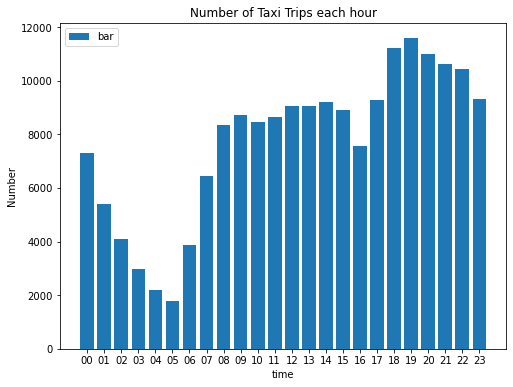

In [28]:
hourly_taxi_trips()

### Visualization 2
Generate a line graph of the average distance traveled per month by Taxi as well as Uber and the corresponding 90% confidence interval. In detail, we calculate each confidence interval of Taxi and Uber by t-distribution.

In [29]:
def monthly_avg_distance():
    """
    Plot the monthly average distance of taxi and uber trips, in line graph
    And calculate the 90% confidence interval then Include the CI around the average distance
    """
    taxi,uber = get_data_for_visual_2()
    
    # calculate 90% CI for Taxi and Uber distance
    mean_t = taxi['avg_dis'].mean() 
    mean_u = uber['avg_dis'].mean()
    std_t = taxi['avg_dis'].sem()    
    std_u = uber['avg_dis'].sem()
    t_low,t_high = stats.t.interval(alpha=0.9, df=len(taxi['avg_dis']) - 1, loc=mean_t, scale=std_t)
    u_low,u_high = stats.t.interval(alpha=0.9, df=len(uber['avg_dis']) - 1, loc=mean_u, scale=std_u)
    CI_taxi = t_high - t_low
    CI_uber = u_high - u_low

    # set figure size and plot 2 lines
    fig = plt.figure(figsize=(10, 8))
    plt.plot(taxi['month'], taxi['avg_dis'], color='blue', label='Taxi')
    plt.plot(uber['month'], uber['avg_dis'], color='green', label='Uber')
    
    # create confidence interval around mean
    plt.fill_between(taxi['month'], taxi['avg_dis']-CI_taxi, taxi['avg_dis']+CI_taxi, color='blue', alpha=0.2)
    plt.fill_between(uber['month'], uber['avg_dis']-CI_uber, uber['avg_dis']+CI_uber, color='green', alpha=0.2)
    
    # Set x-axis, y-axis label and title
    plt.xlabel('month')
    plt.ylabel('Average Distance')
    plt.title('Average distance per month with 90% CI')
    plt.legend(frameon=True, loc="upper left")
    plt.show()


In [30]:
def get_data_for_visual_2():
    """
    write queries to obatin needed data from database
    """
    q_taxi="""SELECT strftime ('%m', pickup_datetime) AS month, AVG(distance) as avg_dis
              FROM taxi_trips
              GROUP BY month
           """
    q_uber="""SELECT strftime ('%m', pickup_datetime) AS month, AVG(distance) as avg_dis
              FROM uber_trips
              GROUP BY month
           """
    df_t = pd.read_sql_query(q_taxi, engine)
    df_u = pd.read_sql_query(q_uber, engine)
    return df_t,df_u

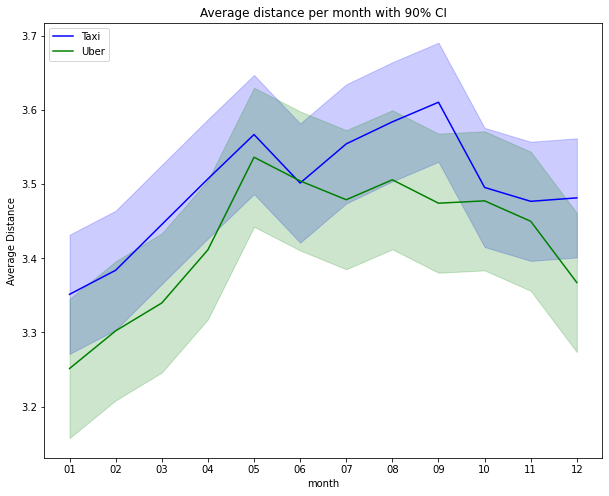

In [31]:
monthly_avg_distance()

### Visualization 3
Set up the coordinates box for LGA, JFK and EWR airport. Then generate a bar chart to compare the dropoffs at these 3 airports throughout the time span. In detail, we calculate the sum of number of dropoffs each day in the week and report the 7-day time span.

In [32]:
def get_data_for_visual_3():
    """
    write queries to obatin needed data from database
    set up BBOX for LGA, JFK and EWR
    """
    bboxes = {
        "LGA": [-73.889473,40.766102,-73.857630,40.782806],
        "JFK" : [-73.826978,40.618945,-73.741319,40.673388],
        "EWR" : [-74.199343,40.668791,-74.150248,40.712069]
    }
    df = pd.DataFrame(index=range(7))
    for (addr, bbox) in bboxes.items():
        query=f"""
        WITH data AS
        (SELECT pickup_datetime, dropoff_latitude, dropoff_longitude FROM uber_trips 
        UNION ALL
        SELECT pickup_datetime, dropoff_latitude, dropoff_longitude FROM taxi_trips)
        
        SELECT count(*) AS {addr}, strftime('%w', pickup_datetime) AS `day_of_week` 
        FROM data WHERE dropoff_longitude>={bbox[0]} and dropoff_longitude<={bbox[2]} 
        and dropoff_latitude>={bbox[1]} and dropoff_latitude<={bbox[3]} 
        GROUP BY `day_of_week`;
        """
        data = pd.read_sql_query(query, engine)
        df = pd.concat([df, data.iloc[:, 0]], axis=1)
    df = pd.DataFrame(df)
    
    # make index as day 1~7
    df.index = df.index.map(lambda x: x+1)
    
    return df

In [33]:
def dropoff_airports():
    """
    Plot the sum of taxi trips of each hour, in bar chart form
    """
    df = get_data_for_visual_3()
    # fetch data from LGA, JFK and EWR
    LGA = df['LGA']
    JFK = df['JFK']
    EWR = df['EWR']
    day = df.index
    
    # set figure size, bar chart
    fig = plt.figure(figsize=(10, 8))
    plt.bar(day, LGA, 0.25,label='LGA')
    plt.bar(day+0.25, JFK, 0.25, label='JFK')
    plt.bar(day+0.5, EWR, 0.25, label='EWR')
    plt.xlabel('Day of week')
    plt.ylabel('Number of dropoffs')
    plt.legend(frameon=True, loc="upper left")
    plt.show()

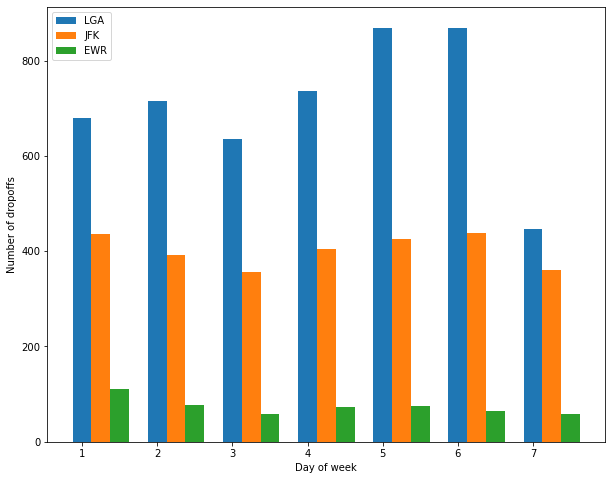

In [34]:
dropoff_airports()

### Visualization 4

Make a heatmap to show density of hired trips within the NYC region. 

In [35]:
def get_data_for_visual_4():
    """
    write queries to obatin needed data from database
    """
    # fetch map information
    g = gpd.read_file(filename='taxi_zones.zip', engine='fiona')
    g = g.to_crs(4326)
    g['longitude'] = g.centroid.x
    g['latitude'] = g.centroid.y
    
    # write queries to fetch latitude and longitude from trips
    query="""
    SELECT pickup_latitude, pickup_longitude FROM uber_trips UNION ALL
    SELECT pickup_latitude, pickup_longitude FROM taxi_trips
    """
    data = pd.read_sql_query(query, engine)
    geoData = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.pickup_longitude, data.pickup_latitude))
    data = g.sjoin(geoData, how="left", predicate="contains")
    
    # count number of rides
    countData = data.groupby(by=["OBJECTID"])["OBJECTID"].count()
    countData.reset_index(inplace=True, drop=True)
    g = g.assign(count=countData)
    
    return g

In [36]:
def hired_trips_heatmap():
    """
    Plot the sum of taxi trips of each hour, in bar chart form
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    df = get_data_for_visual_4()
    df.plot(column='count', scheme="MaxP", k=8, ax=ax, cmap='Pastel2',legend=True,
            missing_kwds={"color": "lightgrey", "edgecolor": "red", "hatch": "///", "label": "Missing values"},
            legend_kwds={"bbox_to_anchor" :(1.8, 1)})


#### The legend on the top right is the interval of each color represents

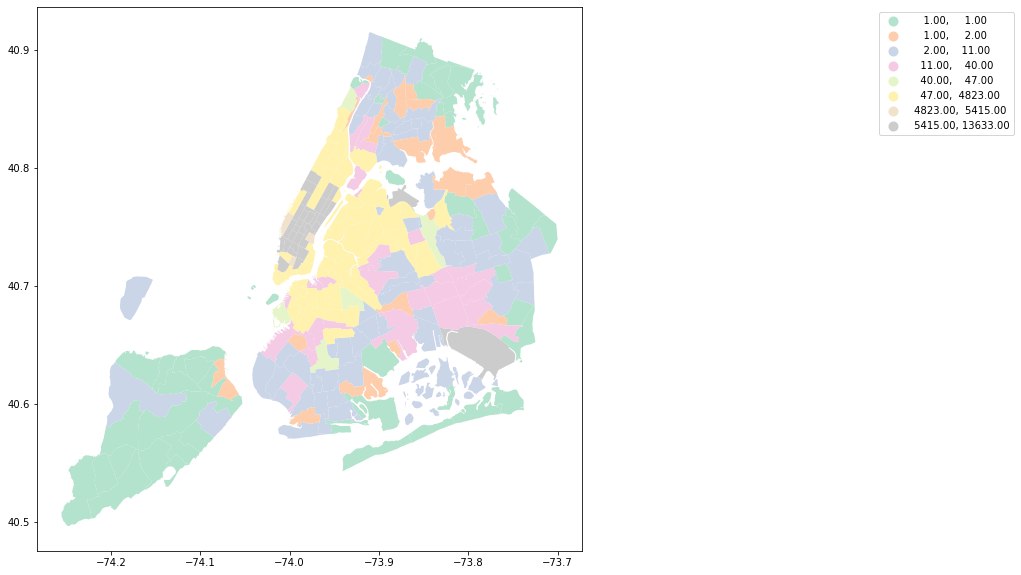

In [37]:
hired_trips_heatmap()

### Visualization 5

Make a scatter plot for revealing relationship between traveled distance and tip amount of Yellow Taxi Trips.

In [38]:
def scatter_tip_distance():
    """
    Plot the scatter graph of distance and tip_amount from Yellow Taxi Trips
    """
    df = get_data_for_visual_5()
    
    # filter those tips are 0, sample size is set to 1000
    df = df[df['tip_amount']>0]
    df = df.sample(1000)
    
    # set figure size and scatter the values
    fig = plt.figure(figsize=(10, 8))
    plt.scatter(df['distance'], df['tip_amount'])
    
    # Set the x-axis, y-axis label and title
    plt.xlabel('Distance')
    plt.ylabel('Tip amount')
    plt.title('Scatter plot of tip amount and distance')    
    plt.show()


In [39]:
def get_data_for_visual_5():
    """
    write queries to obatin needed data from database
    """
    query="""SELECT tip_amount, distance FROM taxi_trips"""
    df = pd.read_sql_query(query, engine)

    return df

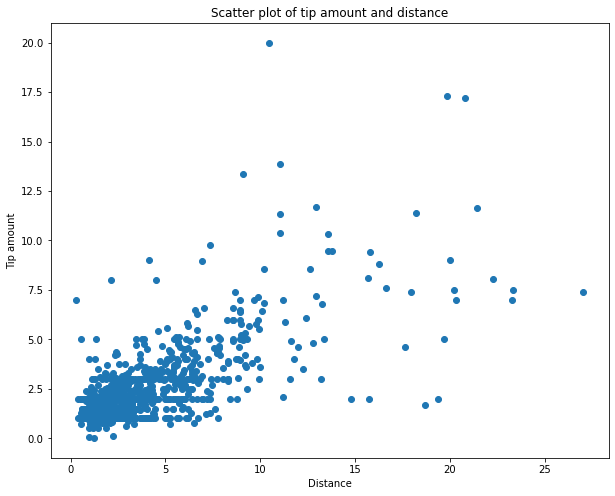

In [40]:
scatter_tip_distance()

### Visualization 6

Make a scatter plot for revealing relationship between precipitation level and tip amount of Yellow Taxi Trips.

In [41]:
def scatter_tip_precipitation():
    """
    Plot the scatter graph of precipitation and tip_amount from Yellow Taxi Trips
    """
    df = get_data_for_visual_6()
    
    # filter those tips are 0, sample size is set 2000
    df = df[df['tip_amount']>0]
    df = df.sample(2000)
    
    # set figure size and scatter the values
    fig = plt.figure(figsize=(10, 8))
    plt.scatter(df['HourlyPrecipitation'], df['tip_amount'])
    
    # Set the x-axis, y-axis label and title
    plt.xlabel('Precipitation')
    plt.ylabel('Tip amount')
    plt.title('Scatter polt of tip amount and precipitation')    
    plt.show()


In [42]:
def get_data_for_visual_6():
    """
    write queries to obatin needed data from database
    """
    query_tip="""SELECT tip_amount, strftime('%Y-%m-%d %H', pickup_datetime) AS date
    FROM taxi_trips
    """
    
    query_rain="""SELECT HourlyPrecipitation, strftime('%Y-%m-%d %H', DATE) AS date
    FROM hourly_weather
    """
    df_tip = pd.read_sql_query(query_tip, engine)
    df_rain = pd.read_sql_query(query_rain, engine)
    
    # merge two dataframe by date
    df = pd.merge(df_tip, df_rain, on='date')
    df = df.drop('date',axis=1)
    
    return df


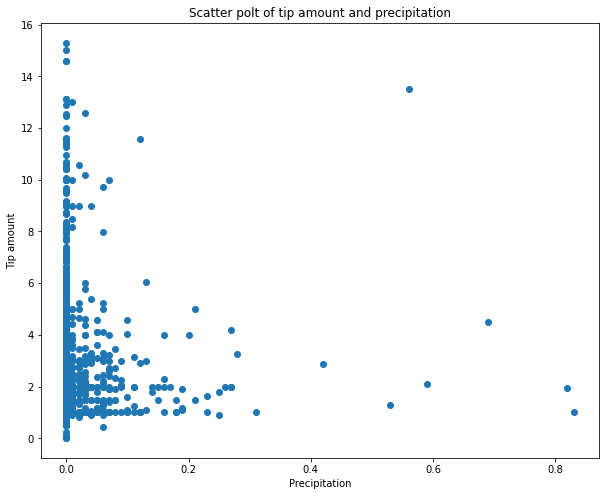

In [43]:
scatter_tip_precipitation()